In [1]:
!pip install matplotlib seaborn torch pandas numpy scikit-learn ucimlrepo

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
import os
import glob # For finding files


# --- Configuration ---
DATASET_ID = 442
# DEVICE_NAME = "Ecobee_Thermostat" # Or any of the 9 devices
# DEVICE_NAMES = ["Danmini_Doorbell", "Ecobee_Thermostat", "Ennio_Doorbell"]
DEVICE_NAMES = ["Danmini_Doorbell", "Ecobee_Thermostat", "Ennio_Doorbell", "Philips_B120N10_Baby_Monitor", "Provision_PT_737E_Security_Camera", "Provision_PT_838_Security_Camera", "Samsung_SNH_1011_N_Webcam", "SimpleHome_XCS7_1002_WHT_Security_Camera", "SimpleHome_XCS7_1003_WHT_Security_Camera"]
BASE_DATA_PATH = "./data" # CHANGE THIS to your extracted dataset path
# Ensure this base path exists, or adapt to how ucimlrepo stores data if using it directly
# For ucimlrepo, it might download to a specific cache location or allow specification.

# --- Fetch and/or Locate Data ---
try:
    # Check if data is already downloaded/extracted by user
    full_df = pd.DataFrame([])
    for DEVICE_NAME in DEVICE_NAMES:
        device_path = os.path.join(BASE_DATA_PATH, DEVICE_NAME)
        if not os.path.exists(device_path):
            print(f"Device data for {DEVICE_NAME} not found at {device_path}.")
            print("Attempting to fetch using ucimlrepo (this might download the whole dataset)...")
            if not os.path.exists(BASE_DATA_PATH):
                os.makedirs(BASE_DATA_PATH)

            iot_botnet_attacks = fetch_ucirepo(id=DATASET_ID)
            # ucimlrepo fetch_ucirepo typically loads data into memory (X, y)
            # and provides metadata. It doesn't directly extract into a file structure
            # like the one N-BaIoT comes in (per-device CSVs).
            # So, for N-BaIoT, manual download and extraction is usually preferred
            # to work with individual device files easily.

            # If you manually downloaded and extracted the ZIP from UCI:
            # The structure is usually:
            # archive.ics.uci.edu/static/public/442/detection+of+iot+botnet+attacks+n+baiot.zip
            # Unzipping this gives you a folder, and inside that, folders for each of the 9 devices.
            # e.g., ./N-BaIoT/1. Danmini_Doorbell/benign_traffic.csv
            # e.g., ./N-BaIoT/1. Danmini_Doorbell/gafgyt_attacks/combo.csv
            # You might need to adjust DEVICE_NAME and paths if your extraction created numbered folders.
            # For now, let's assume you've placed the Danmini_Doorbell files directly under device_path.
            # Example:
            # device_path = "./N-BaIoT_data/Danmini_Doorbell/"
            # benign_file = os.path.join(device_path, "benign_traffic.csv")
            # attack_files_pattern = os.path.join(device_path, "gafgyt_attacks/*.csv") # For Gafgyt
            # attack_files_pattern_mirai = os.path.join(device_path, "mirai_attacks/*.csv") # For Mirai
            print(f"Please ensure you have manually downloaded and extracted the dataset from")
            print(f"https://archive.ics.uci.edu/static/public/442/detection+of+iot+botnet+attacks+n+baiot.zip")
            print(f"into a structure like {BASE_DATA_PATH}/{DEVICE_NAME}/")
            raise FileNotFoundError("Dataset files not found in expected local path.")

        print(f"Using data from: {device_path}")

        # Load benign traffic
        benign_file_path = os.path.join(device_path, "benign_traffic.csv")
        if not os.path.exists(benign_file_path):
            raise FileNotFoundError(f"Benign traffic file not found: {benign_file_path}")
        benign_df = pd.read_csv(benign_file_path)
        benign_df['label'] = 0 # 0 for benign

        # Load attack traffic
        # We'll combine all attacks for that device into a single "attack" class
        attack_dfs = []
        attack_folders = [
            os.path.join(device_path, "gafgyt_attacks"),
            os.path.join(device_path, "mirai_attacks")
        ]

        for folder in attack_folders:
            if os.path.exists(folder):
                # The N-BaIoT dataset description mentions 10 attacks for each device.
                # These are often individual CSV files within the 'gafgyt_attacks' and 'mirai_attacks' subfolders.
                # Example: gafgyt_attacks/combo.csv, gafgyt_attacks/junk.csv, etc.
                # mirai_attacks/ack.csv, mirai_attacks/scan.csv, etc.
                csv_files = glob.glob(os.path.join(folder, "*.csv"))
                if not csv_files:
                    print(f"Warning: No CSV files found in attack folder: {folder}")
                for attack_file in csv_files:
                    try:
                        print(f"Loading attack file: {attack_file}")
                        attack_df_single = pd.read_csv(attack_file)
                        attack_dfs.append(attack_df_single)
                    except Exception as e:
                        print(f"Error loading {attack_file}: {e}")
            else:
                print(f"Warning: Attack folder not found: {folder}")

        if not attack_dfs:
            raise FileNotFoundError(f"No attack traffic files loaded for {DEVICE_NAME}. Check paths and file structure.")

        attack_df_combined = pd.concat(attack_dfs, ignore_index=True)
        attack_df_combined['label'] = 1 # 1 for attack

        # Combine benign and attack data
        full_df = pd.concat([full_df, benign_df, attack_df_combined], ignore_index=True)

    print(f"Full dataset shape: {full_df.shape}")
    print(f"Class distribution:\n{full_df['label'].value_counts()}")

    # Separate features and labels
    X = full_df.drop('label', axis=1).values
    y = full_df['label'].values

    # Data splitting (train, validation, test)
    # First, split into training and temp (validation + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y # stratify is important
    )
    # Then, split temp into validation and test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"Training set shape: {X_train.shape}, {y_train.shape}")
    print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
    print(f"Test set shape: {X_test.shape}, {y_test.shape}")

    # Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val) # Use transform, not fit_transform
    X_test = scaler.transform(X_test) # Use transform, not fit_transform

    print("Data loading and preprocessing complete.")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the N-BaIoT dataset is downloaded, extracted, and the BASE_DATA_PATH is set correctly.")
    print("The expected structure for a device (e.g., Danmini_Doorbell) is:")
    print(f"{BASE_DATA_PATH}/{DEVICE_NAME}/benign_traffic.csv")
    print(f"{BASE_DATA_PATH}/{DEVICE_NAME}/gafgyt_attacks/*.csv")
    print(f"{BASE_DATA_PATH}/{DEVICE_NAME}/mirai_attacks/*.csv")
    # Exit if data can't be loaded
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data preparation: {e}")
    exit()

Using data from: ./detection+of+iot+botnet+attacks+n+baiot\Danmini_Doorbell
Loading attack file: ./detection+of+iot+botnet+attacks+n+baiot\Danmini_Doorbell\gafgyt_attacks\combo.csv
Loading attack file: ./detection+of+iot+botnet+attacks+n+baiot\Danmini_Doorbell\gafgyt_attacks\junk.csv
Loading attack file: ./detection+of+iot+botnet+attacks+n+baiot\Danmini_Doorbell\gafgyt_attacks\scan.csv
Loading attack file: ./detection+of+iot+botnet+attacks+n+baiot\Danmini_Doorbell\gafgyt_attacks\tcp.csv
Loading attack file: ./detection+of+iot+botnet+attacks+n+baiot\Danmini_Doorbell\gafgyt_attacks\udp.csv
Loading attack file: ./detection+of+iot+botnet+attacks+n+baiot\Danmini_Doorbell\mirai_attacks\ack.csv
Loading attack file: ./detection+of+iot+botnet+attacks+n+baiot\Danmini_Doorbell\mirai_attacks\scan.csv
Loading attack file: ./detection+of+iot+botnet+attacks+n+baiot\Danmini_Doorbell\mirai_attacks\syn.csv
Loading attack file: ./detection+of+iot+botnet+attacks+n+baiot\Danmini_Doorbell\mirai_attacks\udp.

In [4]:
import pandas as pd

# This script assumes 'full_df' is available in your notebook's environment.

print("--- Exporting Full Feature Distribution Summary ---")

# 1. Isolate the features from the main DataFrame
features_df = full_df.drop('label', axis=1)

# 2. Calculate the descriptive statistics for all features
feature_stats = features_df.describe().transpose()

# 3. Export the statistics DataFrame to a CSV file
output_filename = 'feature_distribution_summary.csv'
feature_stats.to_csv(output_filename)

print(f"\n✅ Successfully exported the full feature distribution.")
print(f"Please look for the file '{output_filename}' in the file browser to view it.")

--- Exporting Full Feature Distribution Summary ---

✅ Successfully exported the full feature distribution.
Please look for the file 'feature_distribution_summary.csv' in the file browser to view it.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- PyTorch Imports ---
import torch
from torch.utils.data import Dataset, DataLoader

RANDOM_STATE = 42 # For reproducibility
BATCH_SIZE = 64   # Hyperparameter, can be tuned

# (The data loading and preprocessing code from the previous exploration step goes here)
# For brevity, I'll assume X_train, y_train, X_val, y_val, X_test, y_test are available
# Ensure that part of the script has run successfully to produce these variables.

# Placeholder for the data loading and preprocessing logic if you're running this in segments.
# In a full script, this would not be commented out.
# """
try:
    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
    print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")
    print(f"Benign (0) vs Attack (1) in training: {np.bincount(y_train)}")
    print(f"Benign (0) vs Attack (1) in validation: {np.bincount(y_val)}")
    print(f"Benign (0) vs Attack (1) in test: {np.bincount(y_test)}")

except FileNotFoundError as e:
    print(f"ERROR during data loading: {e}")
    print("Please ensure the N-BaIoT dataset is downloaded, extracted, and BASE_DATA_PATH is correct.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data preparation: {e}")
    import traceback
    traceback.print_exc()
    exit()
# """


# --- 3. PyTorch Dataset and DataLoader ---

class NBaIoTDataset(Dataset):
    """
    Custom PyTorch Dataset for the N-BaIoT dataset.
    Assumes features (X) are pre-scaled numerical data and labels (y) are numerical.
    """
    def __init__(self, features, labels, transform=None):
        # Convert to PyTorch tensors
        self.features = torch.tensor(features, dtype=torch.float32)
        # Labels for binary classification with BCEWithLogitsLoss should be float32
        # and often need to be reshaped to [batch_size, 1]
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        self.transform = transform # Optional: for any further transformations on-the-fly

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        sample_features = self.features[idx]
        sample_label = self.labels[idx]

        if self.transform:
            # This is less common for tabular data unless doing complex augmentations
            sample_features = self.transform(sample_features)

        return sample_features, sample_label

# Instantiate the Dataset for training, validation, and test sets
try:
    train_dataset = NBaIoTDataset(X_train, y_train)
    val_dataset = NBaIoTDataset(X_val, y_val)
    test_dataset = NBaIoTDataset(X_test, y_test)

    print(f"\nCreated train_dataset with {len(train_dataset)} samples.")
    print(f"Created val_dataset with {len(val_dataset)} samples.")
    print(f"Created test_dataset with {len(test_dataset)} samples.")

    # Let's check a sample from the train_dataset
    sample_features, sample_label = train_dataset[0]
    print(f"\nSample 0 from train_dataset:")
    print(f"Features shape: {sample_features.shape}, dtype: {sample_features.dtype}")
    print(f"Label shape: {sample_label.shape}, dtype: {sample_label.dtype}, value: {sample_label.item()}")

except NameError:
    print("\nERROR: X_train, y_train etc. are not defined.")
    print("Please ensure the data loading and preprocessing part of the script has run successfully before this step.")
    exit()
except Exception as e:
    print(f"An error occurred during Dataset instantiation: {e}")
    import traceback
    traceback.print_exc()
    exit()


# Create DataLoaders
# DataLoaders provide an iterable over the given dataset, applying batching, shuffling, etc.
try:
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,      # Shuffle training data each epoch
                              num_workers=0)     # 0 for main process, can increase if I/O bound

    val_loader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,     # No need to shuffle validation data
                            num_workers=0)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,     # No need to shuffle test data
                             num_workers=0)

    print(f"\nCreated train_loader with batch_size={BATCH_SIZE}.")
    print(f"Created val_loader with batch_size={BATCH_SIZE}.")
    print(f"Created test_loader with batch_size={BATCH_SIZE}.")

    # Let's iterate over one batch from train_loader to check
    print("\nChecking one batch from train_loader:")
    for features_batch, labels_batch in train_loader:
        print(f"Features batch shape: {features_batch.shape}") # Should be [BATCH_SIZE, num_features]
        print(f"Labels batch shape: {labels_batch.shape}")     # Should be [BATCH_SIZE, 1]
        break # Just check the first batch

except Exception as e:
    print(f"An error occurred during DataLoader creation: {e}")
    import traceback
    traceback.print_exc()
    exit()

print("\nPyTorch Dataset and DataLoader creation complete.")

Training set shape: X=(2315845, 115), y=(2315845,)
Validation set shape: X=(496253, 115), y=(496253,)
Test set shape: X=(496253, 115), y=(496253,)
Benign (0) vs Attack (1) in training: [ 193901 2121944]
Benign (0) vs Attack (1) in validation: [ 41550 454703]
Benign (0) vs Attack (1) in test: [ 41550 454703]

Created train_dataset with 2315845 samples.
Created val_dataset with 496253 samples.
Created test_dataset with 496253 samples.

Sample 0 from train_dataset:
Features shape: torch.Size([115]), dtype: torch.float32
Label shape: torch.Size([1]), dtype: torch.float32, value: 1.0

Created train_loader with batch_size=64.
Created val_loader with batch_size=64.
Created test_loader with batch_size=64.

Checking one batch from train_loader:
Features batch shape: torch.Size([64, 115])
Labels batch shape: torch.Size([64, 1])

PyTorch Dataset and DataLoader creation complete.


In [ ]:
# --- PyTorch Imports ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

BATCH_SIZE = 64
# Model Hyperparameters
# INPUT_SIZE will be determined from data later
HIDDEN_SIZE_1 = 128
HIDDEN_SIZE_2 = 64
HIDDEN_SIZE_3 = 32 # Optional third hidden layer
OUTPUT_SIZE = 1 # For binary classification with BCEWithLogitsLoss
DROPOUT_RATE = 0.3 # Optional dropout rate

# (The data loading, preprocessing, Dataset, and DataLoader code from previous steps goes here)
# For brevity, I'll assume X_train, y_train, etc., and data_loaders are available
# Ensure that part of the script has run successfully.

# Placeholder for the full data prep and DataLoader code
# """
try:
    INPUT_SIZE = X.shape[1] # Get number of features
    class NBaIoTDataset(Dataset):
        def __init__(self, features, labels):
            self.features = torch.tensor(features, dtype=torch.float32)
            self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        def __len__(self): return len(self.features)
        def __getitem__(self, idx): return self.features[idx], self.labels[idx]

    train_dataset = NBaIoTDataset(X_train, y_train)
    val_dataset = NBaIoTDataset(X_val, y_val)
    test_dataset = NBaIoTDataset(X_test, y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"Data preparation and DataLoaders complete. Input size: {INPUT_SIZE}")

except FileNotFoundError as e:
    print(f"ERROR during data loading: {e}")
    print("Please ensure the N-BaIoT dataset is downloaded, extracted, and BASE_DATA_PATH is correct.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data preparation or DataLoader creation: {e}")
    import traceback
    traceback.print_exc()
    exit()
# """

# --- 4. Model Architecture (MLP) ---

class MLPDetector(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, dropout_rate=0.3):
        super(MLPDetector, self).__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size_1)
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(dropout_rate)

        self.layer_2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(dropout_rate)

        # Optional third hidden layer
        # self.layer_3 = nn.Linear(hidden_size_2, HIDDEN_SIZE_3) # Assuming HIDDEN_SIZE_3 is defined
        # self.relu_3 = nn.ReLU()
        # self.dropout_3 = nn.Dropout(dropout_rate)
        # self.output_layer = nn.Linear(HIDDEN_SIZE_3, output_size) # if using 3rd layer

        self.output_layer = nn.Linear(hidden_size_2, output_size)


    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)

        x = self.layer_2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)

        # If using third hidden layer:
        # x = self.layer_3(x)
        # x = self.relu_3(x)
        # x = self.dropout_3(x)

        x = self.output_layer(x)
        return x

# --- Device Configuration (CPU or GPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# --- Instantiate the Model ---
try:
    if 'INPUT_SIZE' not in globals(): # Ensure INPUT_SIZE was set during data loading
        raise NameError("INPUT_SIZE is not defined. Ensure data loading sets this variable based on X.shape[1].")

    model = MLPDetector(
        input_size=INPUT_SIZE,
        hidden_size_1=HIDDEN_SIZE_1,
        hidden_size_2=HIDDEN_SIZE_2,
        output_size=OUTPUT_SIZE,
        dropout_rate=DROPOUT_RATE
    ).to(device) # Move model to the selected device

    print("\nModel instantiated:")
    print(model)

    # Optional: Test with a dummy input batch (if DataLoaders are ready)
    if 'train_loader' in globals():
        print("\nTesting model with a dummy batch from train_loader...")
        try:
            dummy_features, _ = next(iter(train_loader))
            dummy_features = dummy_features.to(device)
            with torch.no_grad(): # No need to compute gradients for this test
                output = model(dummy_features)
            print(f"Dummy batch input shape: {dummy_features.shape}")
            print(f"Model output shape for dummy batch: {output.shape}") # Should be [BATCH_SIZE, OUTPUT_SIZE]
        except Exception as e:
            print(f"Error testing model with dummy batch: {e}")
            print("Ensure train_loader is correctly initialized and data is loaded.")

except NameError as e:
    print(f"\nERROR: {e}")
    print("Please ensure the data loading part (which defines INPUT_SIZE) has run successfully.")
    exit()
except Exception as e:
    print(f"An error occurred during model instantiation or dummy batch test: {e}")
    import traceback
    traceback.print_exc()
    exit()

print("\nMLP model definition and instantiation complete.")

Data preparation and DataLoaders complete. Input size: 115

Using device: cuda

Model instantiated:
MLPDetector(
  (layer_1): Linear(in_features=115, out_features=128, bias=True)
  (relu_1): ReLU()
  (dropout_1): Dropout(p=0.3, inplace=False)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (relu_2): ReLU()
  (dropout_2): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

Testing model with a dummy batch from train_loader...
Dummy batch input shape: torch.Size([64, 115])
Model output shape for dummy batch: torch.Size([64, 1])

MLP model definition and instantiation complete.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # For evaluation

# --- PyTorch Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- Configuration ---
BATCH_SIZE = 64
# Model Hyperparameters
# INPUT_SIZE will be determined from data
HIDDEN_SIZE_1 = 128
HIDDEN_SIZE_2 = 64
OUTPUT_SIZE = 1
DROPOUT_RATE = 0.3
# Training Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 50 # Start with a moderate number, can increase
EARLY_STOPPING_PATIENCE = 5 # Number of epochs to wait for improvement before stopping

# (The data loading, preprocessing, Dataset, DataLoader, and Model definition code from previous steps goes here)
# For brevity, I'll assume these are available.
# Ensure INPUT_SIZE is defined in the data loading part.
# Ensure 'model' is defined and moved to 'device'.
# Ensure 'train_loader', 'val_loader', 'test_loader' are defined.

# Placeholder for the full data prep, DataLoader, and Model code
# """
try:
    class NBaIoTDataset(Dataset):
        def __init__(self, features, labels):
            self.features = torch.tensor(features, dtype=torch.float32)
            self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        def __len__(self): return len(self.features)
        def __getitem__(self, idx): return self.features[idx], self.labels[idx]
    train_dataset=NBaIoTDataset(X_train,y_train); val_dataset=NBaIoTDataset(X_val,y_val); test_dataset=NBaIoTDataset(X_test,y_test)
    train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True); val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False); test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

    class MLPDetector(nn.Module):
        def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, dropout_rate=0.3):
            super().__init__(); self.fc_stack = nn.Sequential(
                nn.Linear(input_size, hidden_size_1), nn.ReLU(), nn.Dropout(dropout_rate),
                nn.Linear(hidden_size_1, hidden_size_2), nn.ReLU(), nn.Dropout(dropout_rate),
                nn.Linear(hidden_size_2, output_size))
        def forward(self, x): return self.fc_stack(x)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLPDetector(INPUT_SIZE, HIDDEN_SIZE_1, HIDDEN_SIZE_2, OUTPUT_SIZE, DROPOUT_RATE).to(device)
    print(f"Data, DataLoaders, Model ready. Using device: {device}. Input size: {INPUT_SIZE}")
    print(model)
except Exception as e: print(f"Error in pre-steps: {e}"); import traceback; traceback.print_exc(); exit()
# """

# --- 5. Training Setup: Loss Function and Optimizer ---
criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logits (handles sigmoid internally)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop Function ---
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for features, labels in dataloader:
        features = features.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * features.size(0)

        # Calculate predictions
        # outputs are logits, apply sigmoid and threshold
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

# --- Evaluation Loop Function ---
def evaluate_epoch(model, dataloader, criterion, device):
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad(): # Disable gradient calculations
        for features, labels in dataloader:
            features = features.to(device)
            labels = labels.to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * features.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    # Ensure all_labels and all_preds are numpy arrays for sklearn metrics
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    epoch_acc = accuracy_score(all_labels, all_preds)
    # For precision, recall, f1, handle UndefinedMetricWarning if a class has no predictions
    # zero_division=0 means if a class is not predicted, its precision/recall will be 0
    epoch_precision = precision_score(all_labels, all_preds, zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, zero_division=0)
    epoch_f1 = f1_score(all_labels, all_preds, zero_division=0)

    return epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1


# --- Main Training Orchestration ---
print("\n--- Starting Training ---")
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_f1s = [] # Track F1 for best model based on F1 or Loss

best_val_loss = float('inf')
epochs_no_improve = 0
best_model_path = "best_nbiot_detector.pth"

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

    # Early stopping and save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  Validation loss improved. Saved best model to {best_model_path}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break
print("\n--- Training Finished ---")

# --- Load Best Model and Test ---
print(f"\n--- Loading best model from {best_model_path} for final testing ---")
try:
    # Re-initialize model architecture before loading state_dict
    # (This is crucial if the script was stopped and restarted,
    # or if model definition is not in the same scope when loading)
    model_for_testing = MLPDetector(INPUT_SIZE, HIDDEN_SIZE_1, HIDDEN_SIZE_2, OUTPUT_SIZE, DROPOUT_RATE).to(device)
    model_for_testing.load_state_dict(torch.load(best_model_path, map_location=device)) # map_location ensures compatibility

    test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_epoch(model_for_testing, test_loader, criterion, device)
    print("\n--- Test Results (using best model on validation) ---")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall:    {test_recall:.4f}")
    print(f"Test F1-Score:  {test_f1:.4f}")

    # Confusion Matrix for Test Set
    model_for_testing.eval()
    all_test_labels = []
    all_test_preds = []
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            outputs = model_for_testing(features)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(np.array(all_test_labels), np.array(all_test_preds))
    print("\nTest Confusion Matrix:")
    print(cm)

except FileNotFoundError:
    print(f"ERROR: Best model file '{best_model_path}' not found. Was training run?")
except Exception as e:
    print(f"An error occurred during testing: {e}")
    import traceback
    traceback.print_exc()

print("\n--- Script Finished ---")

Data, DataLoaders, Model ready. Using device: cuda. Input size: 115
MLPDetector(
  (fc_stack): Sequential(
    (0): Linear(in_features=115, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

--- Starting Training ---
Epoch 1/50:
  Train Loss: 0.0023, Train Acc: 0.9995
  Val Loss:   0.0009, Val Acc:   0.9997, Val Precision: 0.9998, Val Recall: 0.9999, Val F1: 0.9999
  Validation loss improved. Saved best model to best_nbiot_detector.pth
Epoch 2/50:
  Train Loss: 0.0013, Train Acc: 0.9997
  Val Loss:   0.0006, Val Acc:   0.9998, Val Precision: 0.9998, Val Recall: 0.9999, Val F1: 0.9999
  Validation loss improved. Saved best model to best_nbiot_detector.pth
Epoch 3/50:
  Train Loss: 0.0013, Train Acc: 0.9997
  Val Loss:   0.0007, Val Acc:   0.9998, Val Precision: 0.9998, Val Re

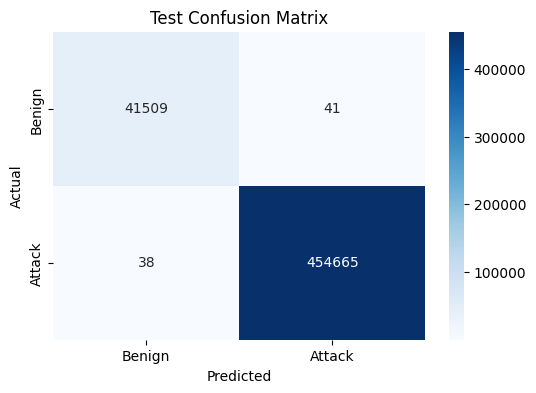

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()


In [ ]:
# --- Save the Scaler ---
import joblib
SCALER_SAVE_PATH = "./app/saved_assets/nbiot_multi_device_scaler.gz"
try:
    joblib.dump(scaler, SCALER_SAVE_PATH)
    print(f"\nScaler saved successfully to {SCALER_SAVE_PATH}")
except Exception as e:
    print(f"Error saving scaler: {e}")

print("\n--- Script Finished (including scaler saving) ---")


Scaler saved successfully to nbiot_multi_device_scaler.gz

--- Script Finished (including scaler saving) ---
